## To-do:

- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.
- Ensure we preserve attributes and mark our changes

In [1]:
import logging

import matplotlib.pyplot as plt
import momepy
from libpysal import graph

from core import algorithms, utils


Set logging level to debug to see the debugging messages.

In [2]:
# Get the logger for core.algorithms.simplify
logger = logging.getLogger('core.algorithms.simplify')
logger.setLevel(logging.DEBUG)

# Set the logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a handler for the logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
_, r_idx = roads.sindex.query(artifacts.geometry, predicate="contains")
roads = roads.drop(roads.index[r_idx])

Filter only singleton artifacts

In [8]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Optionally define a subset of data.

In [9]:
data_sample = artifacts.loc[[6190]]

Simplify singleton artifacts.

In [10]:
new_roads = algorithms.simplify.simplify_singletons(data_sample, roads)

/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Visual exploration of the result.

6190


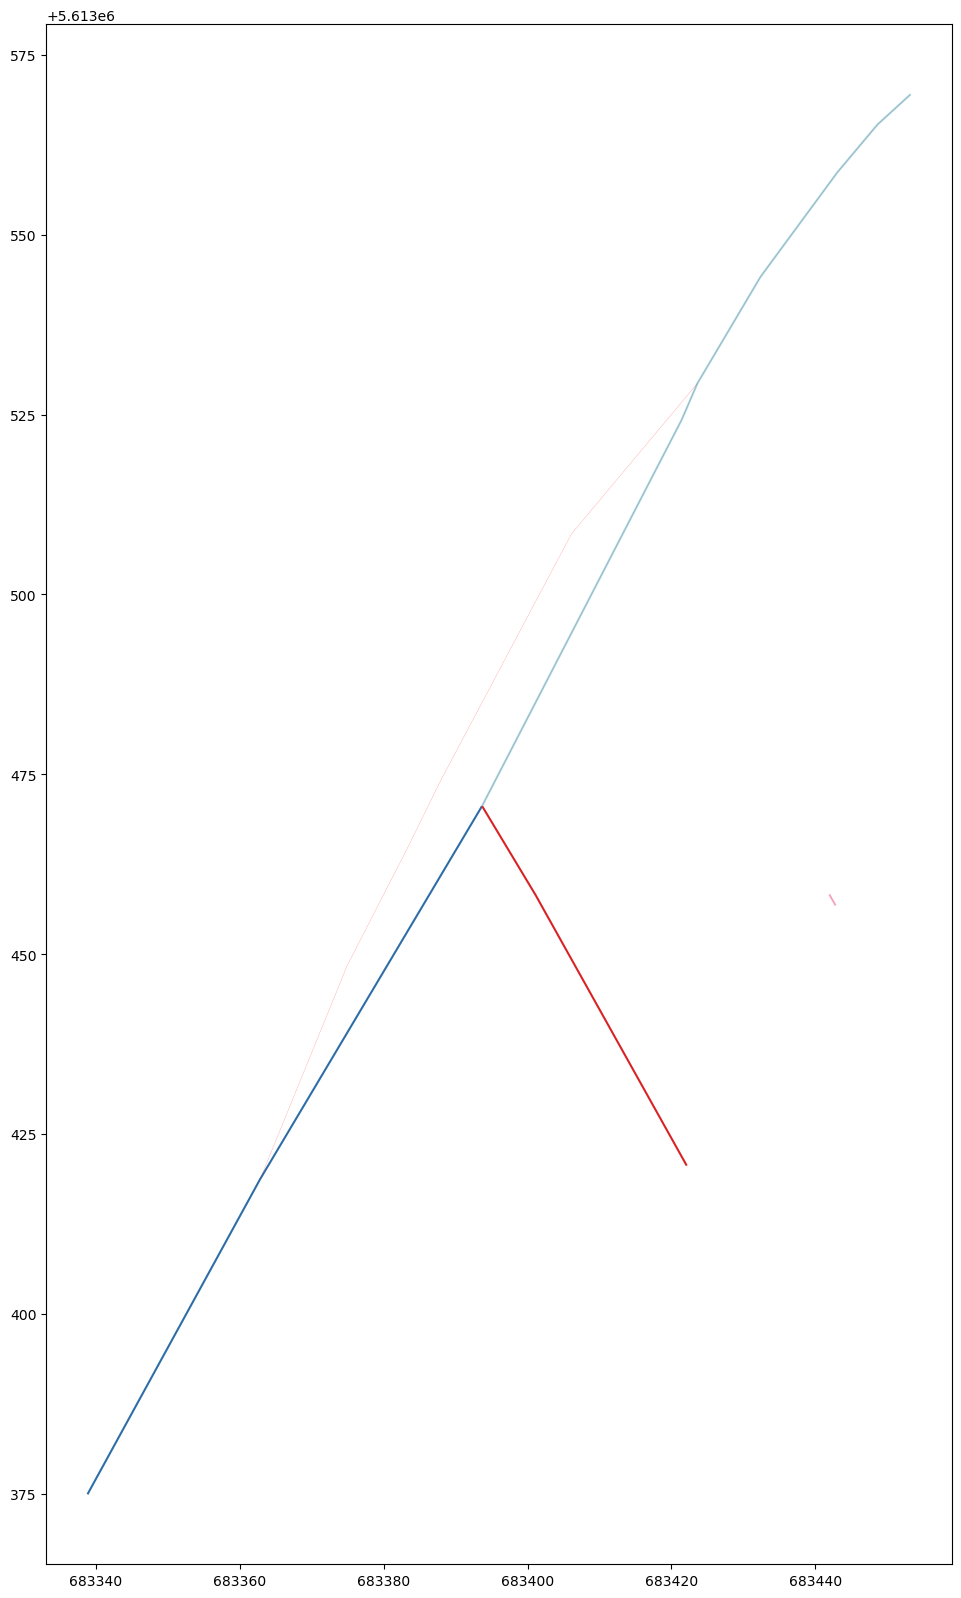

In [11]:
for artifact in data_sample.itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    geom = artifact.geometry
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20", figsize=(20, 20))
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()

In [12]:
new_roads.clip(geom.buffer(50)).reset_index().explore(max_zoom=53)

In [13]:
28789

139, 141

(139, 141)

In [14]:
dangle = new_roads.loc[28789]
cs = new_roads.loc[[139, 141]]

KeyError: 28789

In [ ]:
cs.frechet_distance(dangle.item())

139.0    109.671381
141.0    104.537270
dtype: float64